In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [ ]:
%cd '/content/drive/MyDrive/Politecnico/Mathematics for Machine Learning/Regression tutorial'

/content/drive/MyDrive/Politecnico/Mathematics for Machine Learning/Regression tutorial


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot

In [ ]:
d_types = {'date':str, 'quarter':str, 'department':str, 'day':str, 'team':int,
           'targeted_productivity':float, 'smv':float, 'wip':float, 'over_time':int,
           'incentive':int, 'idle_time':float, 'idle_men':int, 'no_of_style_change':int,
           'no_of_workers':float, 'actual_productivity':float}

df = pd.read_csv("garments_worker_productivity.csv", sep=',', dtype=d_types)
df = df.drop(columns='date')
df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,Quarter2,finishing,Wednesday,9,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [ ]:
df.department.unique()
df['department'] = df['department'].astype('str').apply(lambda x: x.strip())
df.department.unique()

array(['sweing', 'finishing'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   quarter                1197 non-null   object 
 1   department             1197 non-null   object 
 2   day                    1197 non-null   object 
 3   team                   1197 non-null   int64  
 4   targeted_productivity  1197 non-null   float64
 5   smv                    1197 non-null   float64
 6   wip                    691 non-null    float64
 7   over_time              1197 non-null   int64  
 8   incentive              1197 non-null   int64  
 9   idle_time              1197 non-null   float64
 10  idle_men               1197 non-null   int64  
 11  no_of_style_change     1197 non-null   int64  
 12  no_of_workers          1197 non-null   float64
 13  actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 131.0+ 

### targeted_productivity - Actual productivity

Text(0, 0.5, 'Targeted productivity')

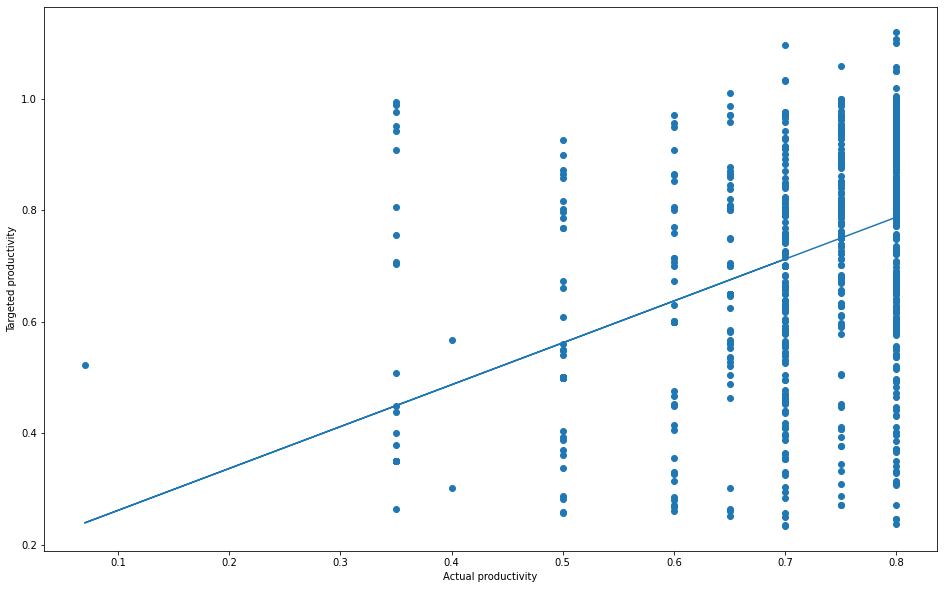

In [ ]:
model = ols("actual_productivity~targeted_productivity", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.targeted_productivity , b0 + b1*df.targeted_productivity )
plt.scatter(df.targeted_productivity, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Targeted productivity")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.178
Model:                             OLS   Adj. R-squared:                  0.177
Method:                  Least Squares   F-statistic:                     258.3
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           9.00e-53
Time:                         13:56:59   Log-Likelihood:                 509.00
No. Observations:                 1197   AIC:                            -1014.
Df Residuals:                     1195   BIC:                            -1004.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [ ]:
dir(fit)
fit.pvalues
# The targeted productivity is strongly correlated to the actual productivity, in fact the explained variance is the 17.8% and
# the p-value is really small. Given an increase of 1 of the targeted productivity the actual productivity on average increase of 0.75.

Intercept                6.948159e-08
targeted_productivity    8.997899e-53
dtype: float64

### smv - Actual productivity

Text(0, 0.5, 'Standard minute value')

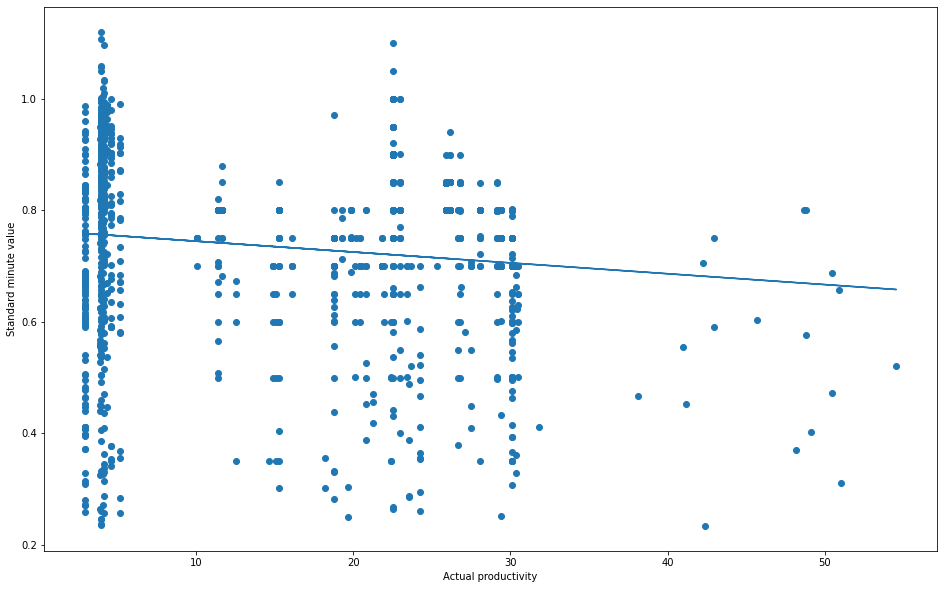

In [ ]:
model = ols("actual_productivity~smv", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.smv , b0 + b1*df.smv )
plt.scatter(df.smv, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Standard minute value")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                  0.014
Method:                  Least Squares   F-statistic:                     18.08
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           2.28e-05
Time:                         13:56:59   Log-Likelihood:                 400.86
No. Observations:                 1197   AIC:                            -797.7
Df Residuals:                     1195   BIC:                            -787.5
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7644      0.009     89.69

In [ ]:
dir(fit)
fit.pvalues
# The smv is not strongly correlated to the actual productivity, the explained variance is around 0.01.
# However the p-value is not so high, so we should continue to consider this predictors.

Intercept    0.000000
smv          0.000023
dtype: float64

### wip - actual productivity

Text(0, 0.5, 'Work in progress')

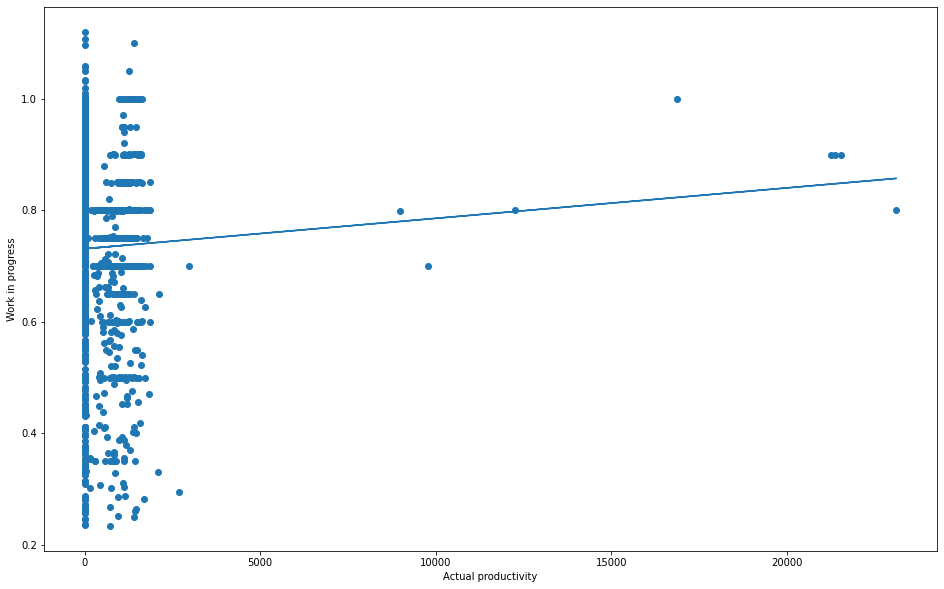

In [ ]:
wip_null_mask = df['wip'].isnull()
df.loc[wip_null_mask, 'wip'] = df.loc[wip_null_mask, 'wip'].fillna(0)

model = ols("actual_productivity~wip", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.wip , b0 + b1*df.wip )
plt.scatter(df.wip, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Work in progress")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                  0.001
Method:                  Least Squares   F-statistic:                     2.690
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):              0.101
Time:                         13:56:59   Log-Likelihood:                 393.22
No. Observations:                 1197   AIC:                            -782.4
Df Residuals:                     1195   BIC:                            -772.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7313      0.006    132.13

In [ ]:
dir(fit)
fit.pvalues
# The p-value is really high, so we cannot reject the hypothesis of the f-statistic such that the coefficient is zero.
# The explained variance is 0.02%, so this predictor will not be considered.

Intercept    0.000000
wip          0.101265
dtype: float64

### over time - actual productivity

Text(0, 0.5, 'Over time')

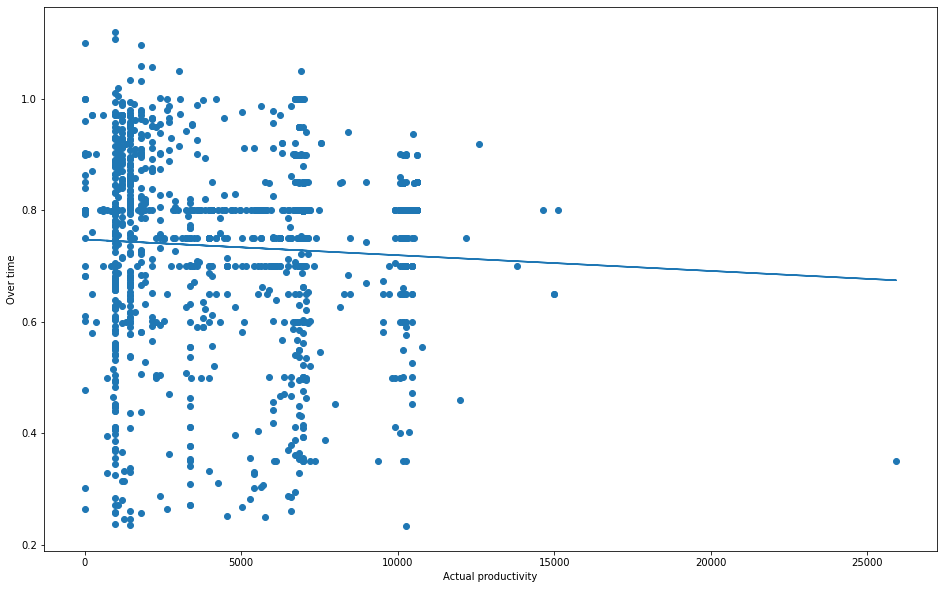

In [ ]:
model = ols("actual_productivity~over_time", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.over_time , b0 + b1*df.over_time )
plt.scatter(df.over_time, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Over time")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.002
Method:                  Least Squares   F-statistic:                     3.522
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):             0.0608
Time:                         13:57:00   Log-Likelihood:                 393.63
No. Observations:                 1197   AIC:                            -783.3
Df Residuals:                     1195   BIC:                            -773.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7480      0.009     87.76

In [ ]:
dir(fit)
fit.pvalues
# Also in this case the p-value is very high, so the coefficient of this predictor is very close to zero and it is not relevant.

Intercept    0.000000
over_time    0.060818
dtype: float64

### incentive - actual productivity

Text(0, 0.5, 'Incentive')

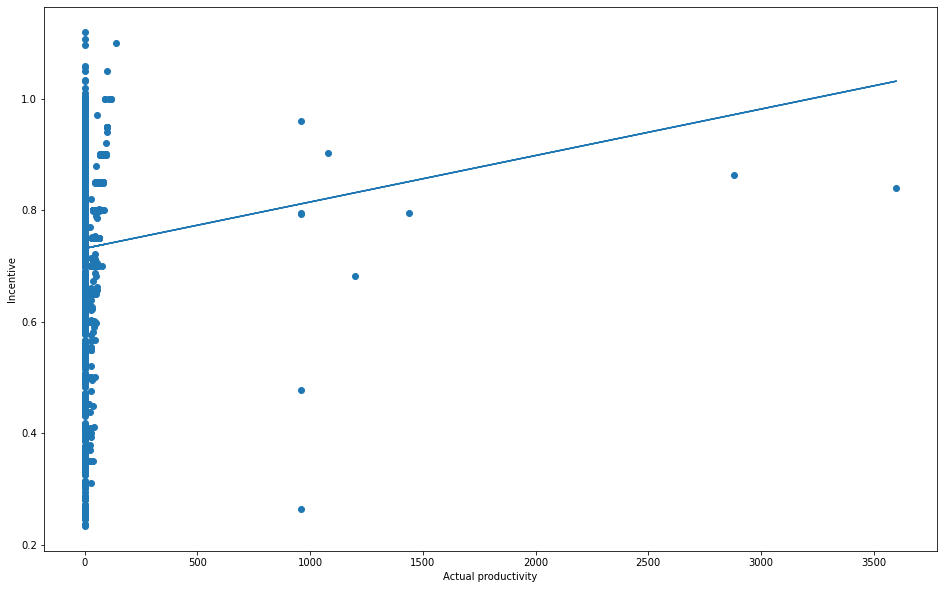

In [ ]:
model = ols("actual_productivity~incentive", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.incentive , b0 + b1*df.incentive )
plt.scatter(df.incentive, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("Incentive")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.006
Model:                             OLS   Adj. R-squared:                  0.005
Method:                  Least Squares   F-statistic:                     7.042
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):            0.00807
Time:                         13:57:00   Log-Likelihood:                 395.39
No. Observations:                 1197   AIC:                            -786.8
Df Residuals:                     1195   BIC:                            -776.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7319      0.005    141.51

In [ ]:
dir(fit)
fit.pvalues
# The coefficent is very close to zero, the p-value also is not really small, and the explained variance is only the 0.06%

Intercept    0.00000
incentive    0.00807
dtype: float64

### idle_time - actual productivity

Text(0, 0.5, 'idle time')

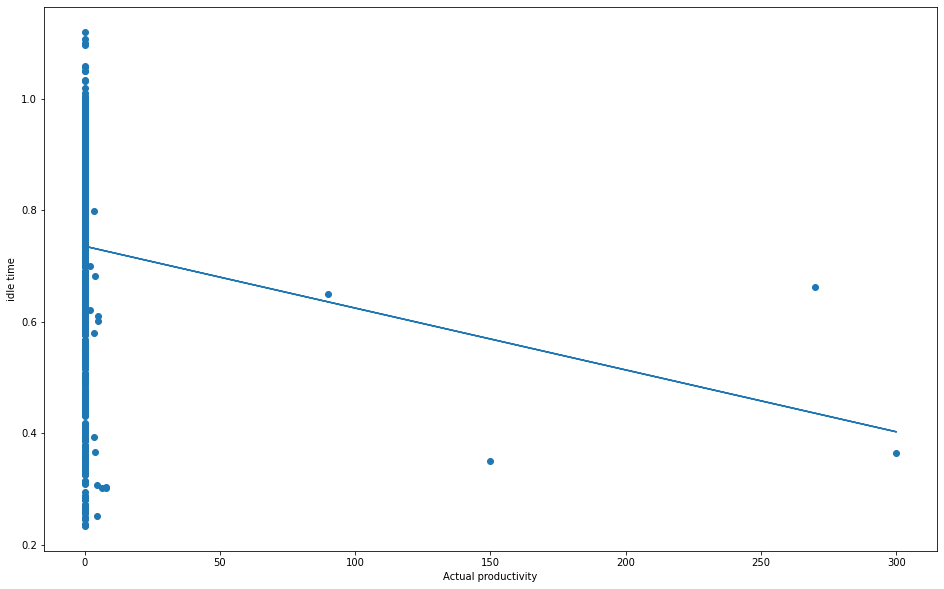

In [ ]:
model = ols("actual_productivity~idle_time", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.idle_time , b0 + b1*df.idle_time)
plt.scatter(df.idle_time, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("idle time")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.007
Model:                             OLS   Adj. R-squared:                  0.006
Method:                  Least Squares   F-statistic:                     7.863
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):            0.00513
Time:                         13:57:00   Log-Likelihood:                 395.80
No. Observations:                 1197   AIC:                            -787.6
Df Residuals:                     1195   BIC:                            -777.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7359      0.005    146.09

In [ ]:
dir(fit)
fit.pvalues
# The coefficient related to idle time is very close to zero, the p-value is small (0.005), the explained variable is 0.6%

Intercept    0.000000
idle_time    0.005128
dtype: float64

### idle_men - actual productivity

Text(0, 0.5, 'idle men')

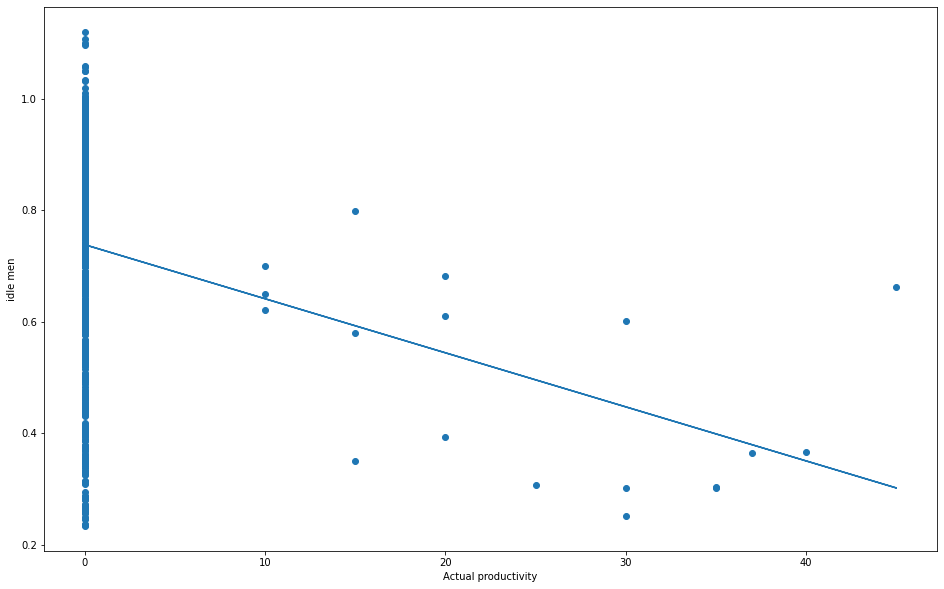

In [ ]:
model = ols("actual_productivity~idle_men", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.idle_men , b0 + b1*df.idle_men)
plt.scatter(df.idle_men, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("idle men")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.033
Model:                             OLS   Adj. R-squared:                  0.032
Method:                  Least Squares   F-statistic:                     40.82
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           2.39e-10
Time:                         13:57:01   Log-Likelihood:                 411.97
No. Observations:                 1197   AIC:                            -819.9
Df Residuals:                     1195   BIC:                            -809.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7387      0.005    147.94

In [ ]:
dir(fit)
fit.pvalues
# Idle men has a very small p-value and an explained variance of 3%, so we should take it into account

Intercept    0.000000e+00
idle_men     2.391453e-10
dtype: float64

### no_of_style_change - actual productivity

Text(0, 0.5, 'no_of_style_change')

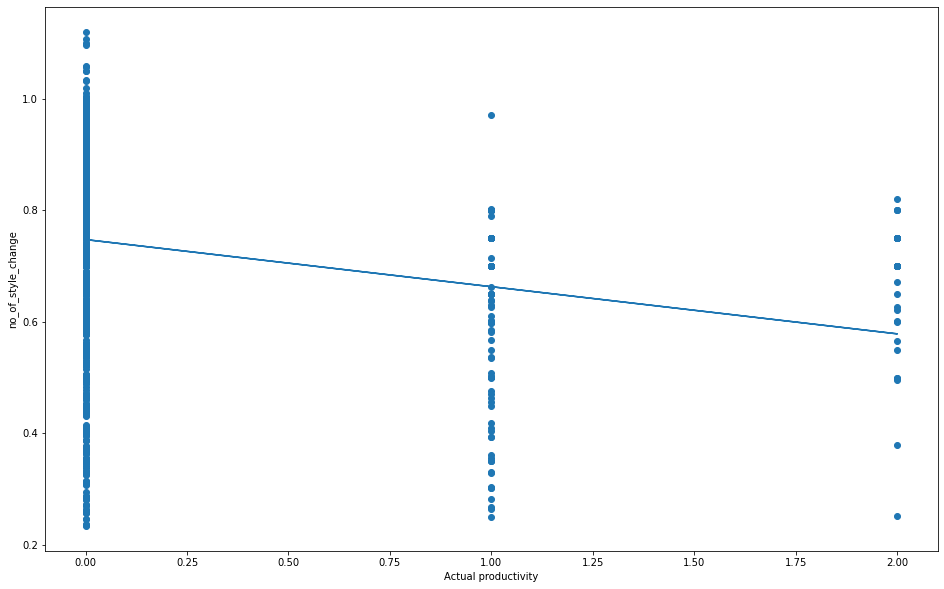

In [ ]:
model = ols("actual_productivity~no_of_style_change", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.no_of_style_change , b0 + b1*df.no_of_style_change)
plt.scatter(df.no_of_style_change, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("no_of_style_change")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.043
Model:                             OLS   Adj. R-squared:                  0.042
Method:                  Least Squares   F-statistic:                     53.69
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           4.30e-13
Time:                         13:57:01   Log-Likelihood:                 418.18
No. Observations:                 1197   AIC:                            -832.4
Df Residuals:                     1195   BIC:                            -822.2
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.7

In [ ]:
dir(fit)
fit.pvalues
# The number of style change has a very small p-value and an explained variance of 4%, so we need to take it into consideration.
# For an increase of 1 of the number of style change the average productivity decrease of 0.08.

Intercept             0.000000e+00
no_of_style_change    4.299784e-13
dtype: float64

### no_of_workers - actual productivity

Text(0, 0.5, 'no_of_workers')

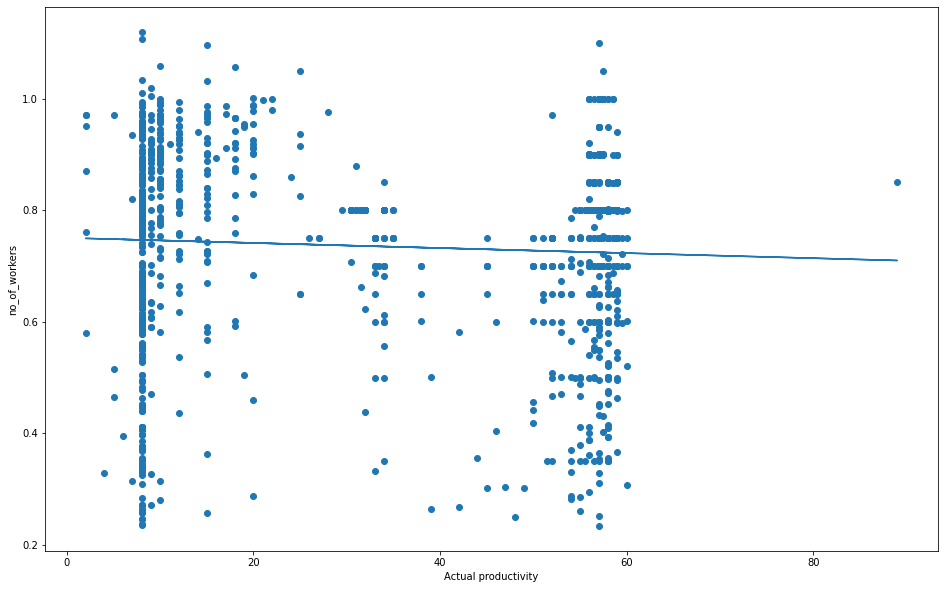

In [ ]:
model = ols("actual_productivity~no_of_workers", data=df) # define the model
fit = model.fit() #fit the model defined above
b0, b1 = fit.params
plt.figure(figsize=(16,10))
plt.plot(df.no_of_workers , b0 + b1*df.no_of_workers)
plt.scatter(df.no_of_workers, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("no_of_workers")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                  0.003
Method:                  Least Squares   F-statistic:                     4.032
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):             0.0449
Time:                         13:57:01   Log-Likelihood:                 393.89
No. Observations:                 1197   AIC:                            -783.8
Df Residuals:                     1195   BIC:                            -773.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7509      0.009 

In [ ]:
fit.pvalues
# The p-value is quite high, so there is a weak correlation between the number of worker and the response variable

Intercept        0.000000
no_of_workers    0.044863
dtype: float64

### quarter - actual productivity

Text(0, 0.5, 'quarter')

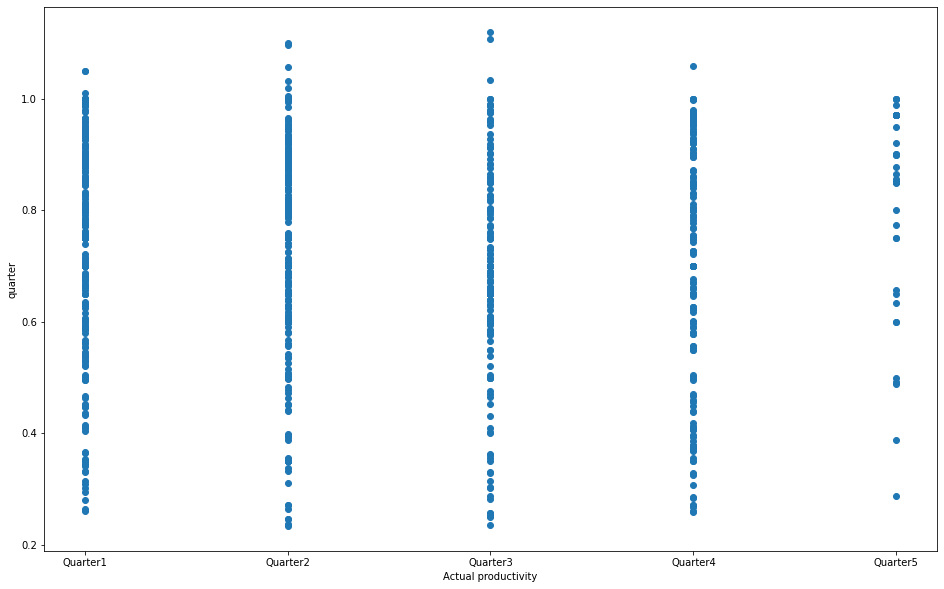

In [ ]:
model = ols("actual_productivity~C(quarter)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.quarter, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("quarter")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.023
Model:                             OLS   Adj. R-squared:                  0.020
Method:                  Least Squares   F-statistic:                     7.112
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           1.17e-05
Time:                         13:57:02   Log-Likelihood:                 405.99
No. Observations:                 1197   AIC:                            -802.0
Df Residuals:                     1192   BIC:                            -776.5
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [ ]:
dir(fit)
fit.pvalues

Intercept                 0.000000
C(quarter)[T.Quarter2]    0.549512
C(quarter)[T.Quarter3]    0.001850
C(quarter)[T.Quarter4]    0.002931
C(quarter)[T.Quarter5]    0.006929
dtype: float64

### department - actual productivity

Text(0, 0.5, 'department')

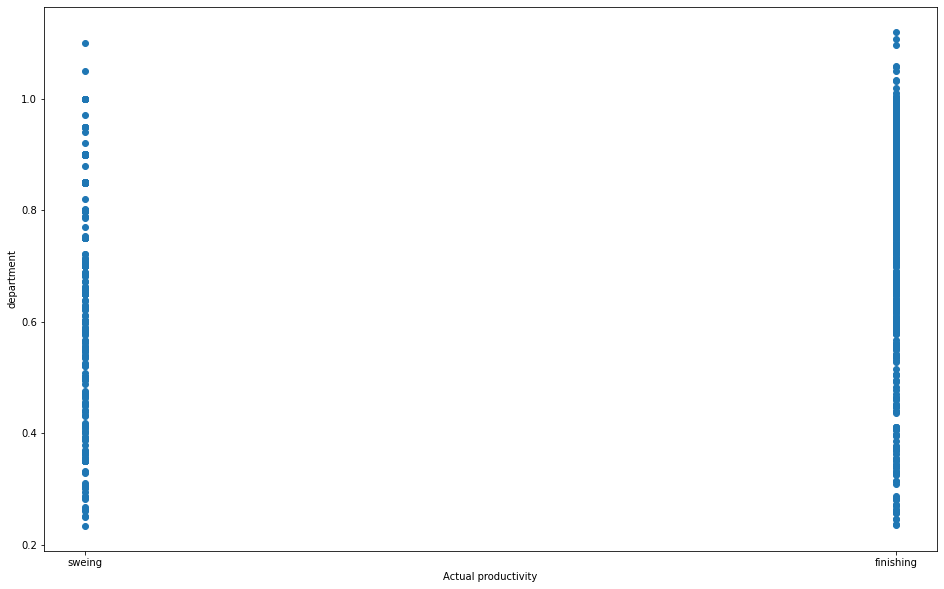

In [ ]:
model = ols("actual_productivity~C(department)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.department, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("department")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.008
Model:                             OLS   Adj. R-squared:                  0.007
Method:                  Least Squares   F-statistic:                     9.246
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):            0.00241
Time:                         13:57:02   Log-Likelihood:                 396.49
No. Observations:                 1197   AIC:                            -789.0
Df Residuals:                     1195   BIC:                            -778.8
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

In [ ]:
dir(fit)
fit.pvalues

Intercept                  0.000000
C(department)[T.sweing]    0.002411
dtype: float64

### day - actual productivity

Text(0, 0.5, 'day')

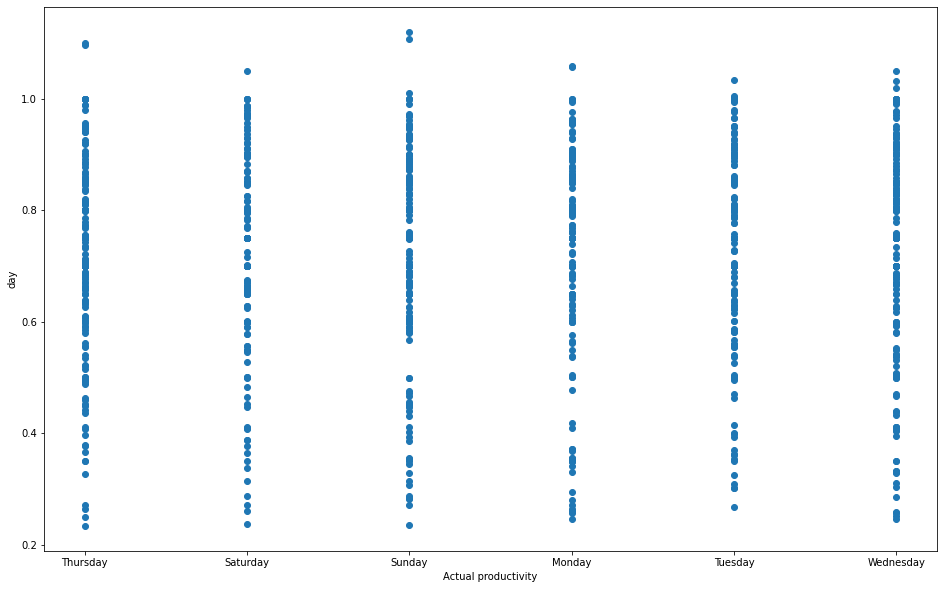

In [ ]:
model = ols("actual_productivity~C(day)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.day, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("day")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.003
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                    0.7121
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):              0.614
Time:                         13:57:02   Log-Likelihood:                 393.66
No. Observations:                 1197   AIC:                            -775.3
Df Residuals:                     1191   BIC:                            -744.8
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

### team - actual productivity

Text(0, 0.5, 'team')

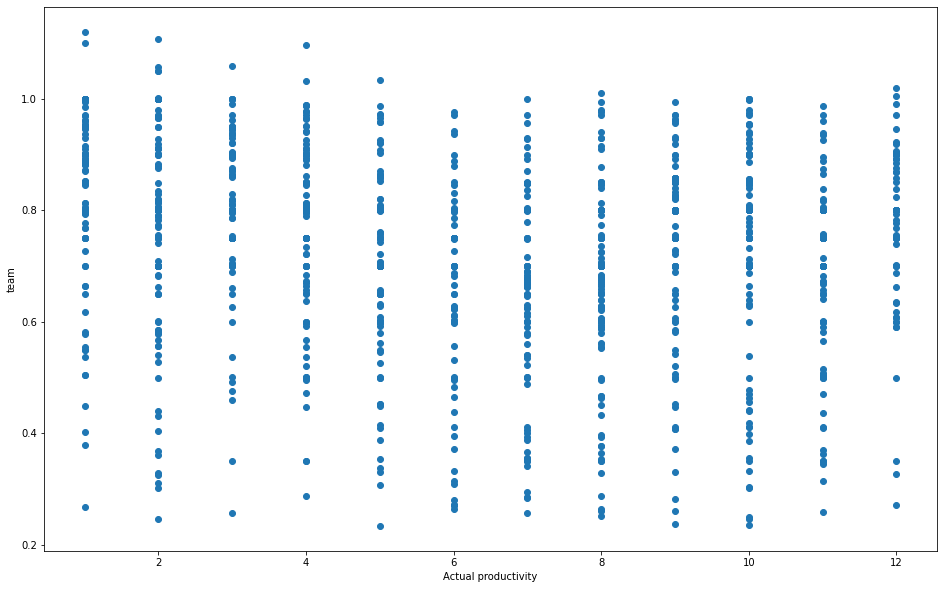

In [ ]:
model = ols("actual_productivity~C(team)", data=df) # define the model
fit = model.fit() #fit the model defined above
plt.figure(figsize=(16,10))
plt.scatter(df.team, df.actual_productivity)
plt.xlabel("Actual productivity")
plt.ylabel("team")

In [ ]:
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.087
Model:                             OLS   Adj. R-squared:                  0.078
Method:                  Least Squares   F-statistic:                     10.21
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           5.16e-18
Time:                         13:57:03   Log-Likelihood:                 446.09
No. Observations:                 1197   AIC:                            -868.2
Df Residuals:                     1185   BIC:                            -807.1
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8211      0.016 

In [ ]:
fit.pvalues

Intercept        9.708993e-296
C(team)[T.2]      2.862629e-02
C(team)[T.3]      4.692225e-01
C(team)[T.4]      2.753657e-02
C(team)[T.5]      2.908085e-07
C(team)[T.6]      1.484493e-08
C(team)[T.7]      1.436777e-10
C(team)[T.8]      2.060983e-10
C(team)[T.9]      1.958088e-04
C(team)[T.10]     1.630415e-05
C(team)[T.11]     1.176695e-08
C(team)[T.12]     7.378823e-02
dtype: float64

### Forward selection

In [ ]:
# Only features are selected that have a Pvalue of at most 0.05

remaining_features = {'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men',
                      'no_of_style_change', 'no_of_workers', 'C(quarter)', 'C(department)', 'C(day)', 'C(team)'}
selected_features = []
while remaining_features:
  PF = [] #list of (P value , feature)
  for f in remaining_features:
      temp = selected_features + [f] #temporary list of features
      formula = 'actual_productivity~' + '+'.join(temp)
      fit = ols(formula ,data=df).fit()
      pval= fit.pvalues[-1]
      if pval < 0.05:
        PF.append((pval ,f))
  if PF: #if not empty
      PF.sort(reverse=True)
      (best_pval , best_f) = PF.pop()
      remaining_features.remove(best_f)
      print('feature {} with P-value = {:.2E}'.format(best_f , best_pval))
      selected_features.append(best_f)
  else:
    break

feature targeted_productivity with P-value = 9.00E-53
feature C(day) with P-value = 1.35E-52
feature C(quarter) with P-value = 7.11E-52
feature C(department) with P-value = 5.73E-51
feature C(team) with P-value = 9.90E-47
feature idle_men with P-value = 9.97E-08
feature smv with P-value = 1.10E-07
feature no_of_workers with P-value = 7.80E-09
feature no_of_style_change with P-value = 4.46E-03
feature over_time with P-value = 2.75E-02


### Testing models

#### targeted_productivity+idle_men

In [ ]:
model = ols("actual_productivity~targeted_productivity+idle_men", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.203
Model:                             OLS   Adj. R-squared:                  0.202
Method:                  Least Squares   F-statistic:                     152.2
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           1.36e-59
Time:                         13:57:06   Log-Likelihood:                 527.76
No. Observations:                 1197   AIC:                            -1050.
Df Residuals:                     1194   BIC:                            -1034.
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

In [ ]:
print(fit.pvalues)
print(fit.aic)

Intercept                4.246600e-09
targeted_productivity    3.815432e-52
idle_men                 9.609584e-10
dtype: float64
-1049.5113427043334


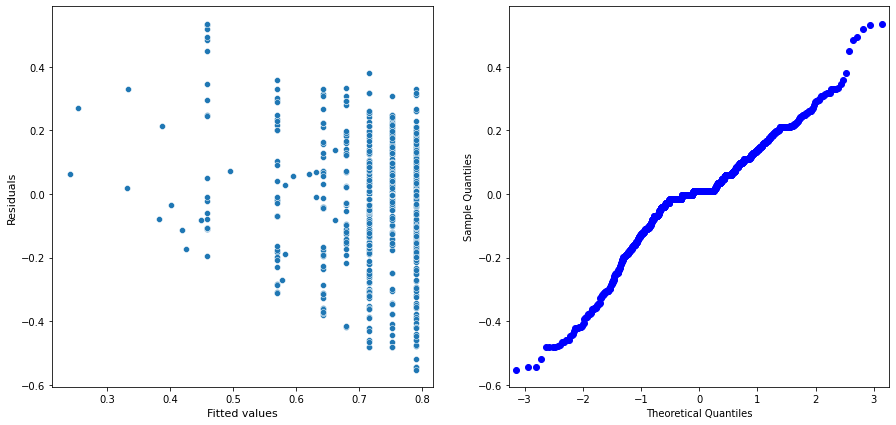

In [ ]:
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(15,7))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 

ax2 = sm.qqplot(fit.resid, ax=ax2)

# The plot between the residuals and the fitted value is not so widely spread as expected, 
# maybe we can try to apply a log transformation to the response variable,
# because with this settings the errors are not performing like iid random variables

### applying log transformation to the response variable

In [ ]:
df["actual_productivity_log"] = np.log(df.actual_productivity)
df

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,actual_productivity_log
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,-0.061104
1,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,-0.120474
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,-0.222431
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,-0.222431
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,-0.222666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,Quarter2,finishing,Wednesday,10,0.75,2.90,0.0,960,0,0.0,0,0,8.0,0.628333,-0.464684
1193,Quarter2,finishing,Wednesday,8,0.70,3.90,0.0,960,0,0.0,0,0,8.0,0.625625,-0.469004
1194,Quarter2,finishing,Wednesday,7,0.65,3.90,0.0,960,0,0.0,0,0,8.0,0.625625,-0.469004
1195,Quarter2,finishing,Wednesday,9,0.75,2.90,0.0,1800,0,0.0,0,0,15.0,0.505889,-0.681438


In [ ]:
model = ols("actual_productivity_log~targeted_productivity+idle_men", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())

                               OLS Regression Results                              
Dep. Variable:     actual_productivity_log   R-squared:                       0.207
Model:                                 OLS   Adj. R-squared:                  0.205
Method:                      Least Squares   F-statistic:                     155.5
Date:                     Fri, 30 Jul 2021   Prob (F-statistic):           9.57e-61
Time:                             13:57:07   Log-Likelihood:                -75.144
No. Observations:                     1197   AIC:                             156.3
Df Residuals:                         1194   BIC:                             171.6
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

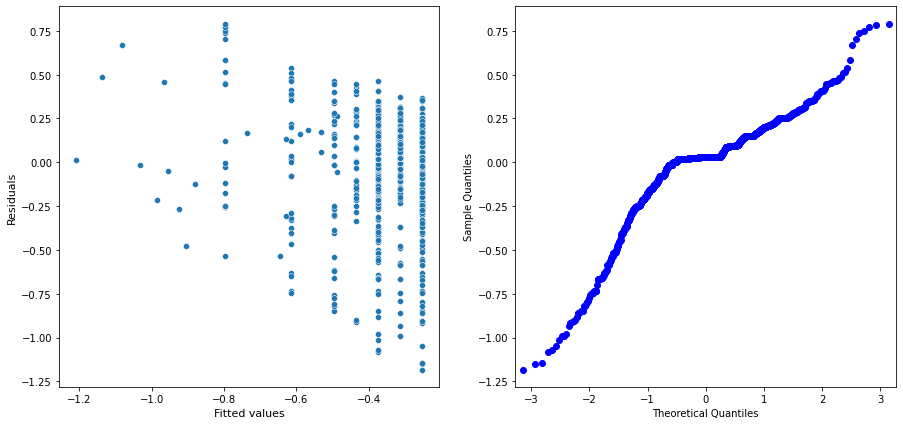

In [ ]:
fig, ( ax1, ax2 )= plt.subplots(1,2,figsize=(15,7))
ax1= sns.scatterplot(data=fit, x=fit.fittedvalues, y=fit.resid, ax=ax1)
ax1.set_ylabel("Residuals", fontsize=11) 
ax1.set_xlabel("Fitted values", fontsize=11) 

ax2 = sm.qqplot(fit.resid, ax=ax2)

### Interaction plot

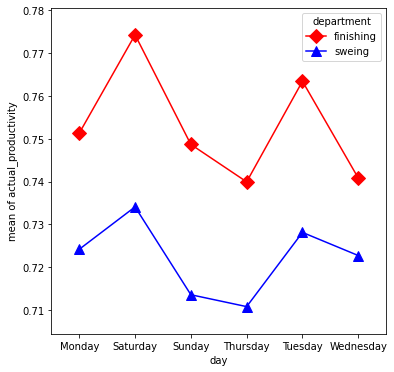

In [ ]:
# Interaction between day and department (no interaction)
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(x=df.day, trace=df.department, response=df.actual_productivity,
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)

#### actual_productivity_log~targeted_productivity*idle_men

In [ ]:
model = ols("actual_productivity_log~targeted_productivity*idle_men", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())

                               OLS Regression Results                              
Dep. Variable:     actual_productivity_log   R-squared:                       0.207
Model:                                 OLS   Adj. R-squared:                  0.205
Method:                      Least Squares   F-statistic:                     103.7
Date:                     Fri, 30 Jul 2021   Prob (F-statistic):           1.17e-59
Time:                             13:57:08   Log-Likelihood:                -74.994
No. Observations:                     1197   AIC:                             158.0
Df Residuals:                         1193   BIC:                             178.3
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
print(fit.pvalues)
print(fit.aic)

Intercept                         3.094894e-87
targeted_productivity             6.378113e-51
idle_men                          5.943379e-01
targeted_productivity:idle_men    5.851376e-01
dtype: float64
157.98842970673104


In [ ]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform
df["actual_productivity_normal"] = quantile_transform(df['actual_productivity'].to_frame(),
                             n_quantiles=900,
                             output_distribution='normal',
                             copy=True).squeeze()


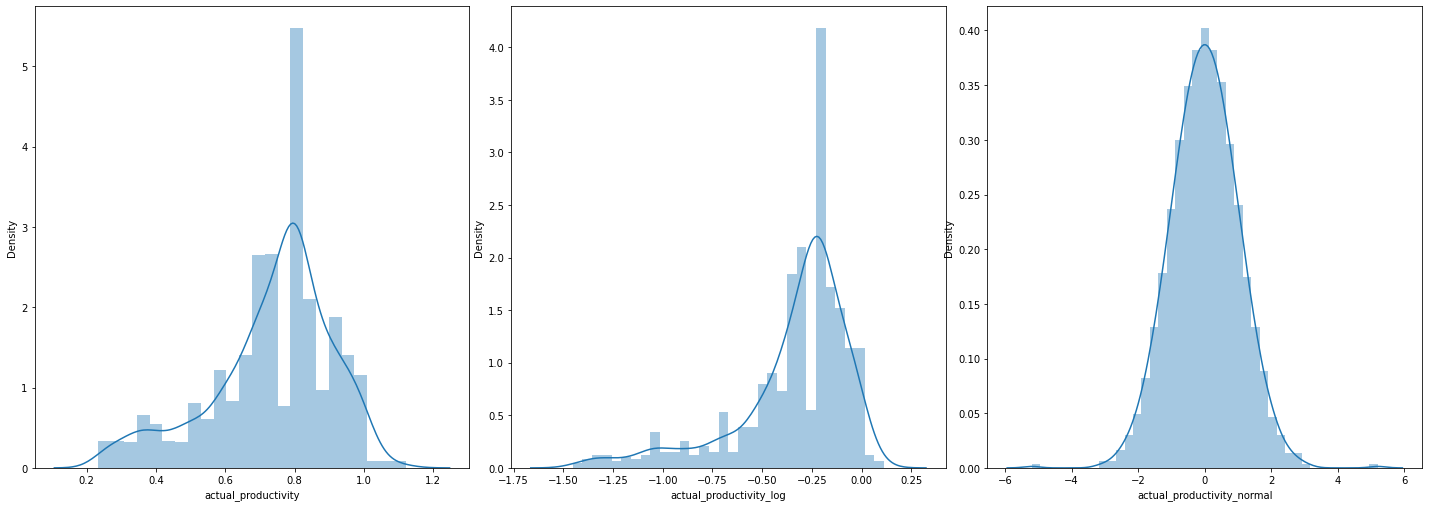

In [ ]:
fig, ( ax1, ax2, ax3 )= plt.subplots(1,3,figsize=(20,7))
plt.tight_layout()
sns.distplot(df['actual_productivity'], ax=ax1)
sns.distplot(df['actual_productivity_log'], ax=ax2)
sns.distplot(df["actual_productivity_normal"], ax=ax3)
plt.show() 

In [ ]:
model = ols("actual_productivity_normal~targeted_productivity*idle_men", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())

                                OLS Regression Results                                
Dep. Variable:     actual_productivity_normal   R-squared:                       0.163
Model:                                    OLS   Adj. R-squared:                  0.161
Method:                         Least Squares   F-statistic:                     77.57
Date:                        Fri, 30 Jul 2021   Prob (F-statistic):           7.70e-46
Time:                                13:57:09   Log-Likelihood:                -1611.3
No. Observations:                        1197   AIC:                             3231.
Df Residuals:                            1193   BIC:                             3251.
Df Model:                                   3                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
print(fit.pvalues)
print(fit.aic)

Intercept                         1.797154e-40
targeted_productivity             1.445686e-41
idle_men                          7.688906e-01
targeted_productivity:idle_men    2.690631e-01
dtype: float64
3230.5676682080466


In [ ]:
# The model with no transformation gives me higher AIC and the log transformation raised a litte the R2, so we can try for the log

#### actual_productivity_log~targeted_productivity+idle_men+smv+C(day)+C(department)+C(team)+no_of_workers+no_of_style_change+over_time+incentive

In [ ]:
model = ols("actual_productivity_log~targeted_productivity+idle_men+smv+C(day)+C(department)+C(team)+no_of_workers+no_of_style_change+over_time+incentive", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())

                               OLS Regression Results                              
Dep. Variable:     actual_productivity_log   R-squared:                       0.294
Model:                                 OLS   Adj. R-squared:                  0.280
Method:                      Least Squares   F-statistic:                     20.34
Date:                     Fri, 30 Jul 2021   Prob (F-statistic):           2.80e-72
Time:                             14:12:57   Log-Likelihood:                -5.2833
No. Observations:                     1197   AIC:                             60.57
Df Residuals:                         1172   BIC:                             187.8
Df Model:                               24                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [ ]:
print(fit.pvalues)
print(fit.aic)

Intercept                  1.906051e-55
C(day)[T.Saturday]         1.154568e-01
C(day)[T.Sunday]           9.476366e-01
C(day)[T.Thursday]         6.778597e-01
C(day)[T.Tuesday]          1.386101e-01
C(day)[T.Wednesday]        7.816949e-01
C(department)[T.sweing]    2.664616e-01
C(team)[T.2]               3.656702e-02
C(team)[T.3]               9.006905e-01
C(team)[T.4]               5.173982e-01
C(team)[T.5]               3.206013e-02
C(team)[T.6]               1.868576e-04
C(team)[T.7]               3.559733e-05
C(team)[T.8]               1.303915e-04
C(team)[T.9]               9.221811e-05
C(team)[T.10]              3.815689e-05
C(team)[T.11]              1.338248e-07
C(team)[T.12]              1.643559e-01
targeted_productivity      5.465120e-44
idle_men                   1.113190e-10
smv                        9.393372e-11
no_of_workers              7.413914e-08
no_of_style_change         6.250146e-04
over_time                  1.550963e-02
incentive                  1.056924e-01


In [ ]:
model = ols("actual_productivity~targeted_productivity+C(day)+C(department)+\
             C(team)+no_of_workers+no_of_style_change+over_time+incentive+idle_men+smv", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print(fit.pvalues)
print(fit.aic)

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.310
Model:                             OLS   Adj. R-squared:                  0.297
Method:                  Least Squares   F-statistic:                     22.93
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           1.38e-78
Time:                         14:17:14   Log-Likelihood:                 614.09
No. Observations:                 1197   AIC:                            -1180.
Df Residuals:                     1173   BIC:                            -1058.
Df Model:                           23                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

In [ ]:
table = sm.stats.anova_lm(fit)
print(table)

                           df     sum_sq   mean_sq           F        PR(>F)
C(day)                    5.0   0.108534  0.021707    1.015418  4.070839e-01
C(department)             1.0   0.274980  0.274980   12.863228  3.489060e-04
C(team)                  11.0   3.119706  0.283610   13.266935  4.033500e-24
targeted_productivity     1.0   5.347712  5.347712  250.159866  3.212477e-51
idle_men                  1.0   0.682608  0.682608   31.931630  2.003698e-08
smv                       1.0   0.630138  0.630138   29.477127  6.873187e-08
no_of_workers             1.0   0.669842  0.669842   31.334453  2.703125e-08
no_of_style_change        1.0   0.281793  0.281793   13.181940  2.948587e-04
over_time                 1.0   0.178663  0.178663    8.357646  3.911525e-03
incentive                 1.0   0.065421  0.065421    3.060329  8.048715e-02
Residual               1172.0  25.054053  0.021377         NaN           NaN


### Pearson correlation

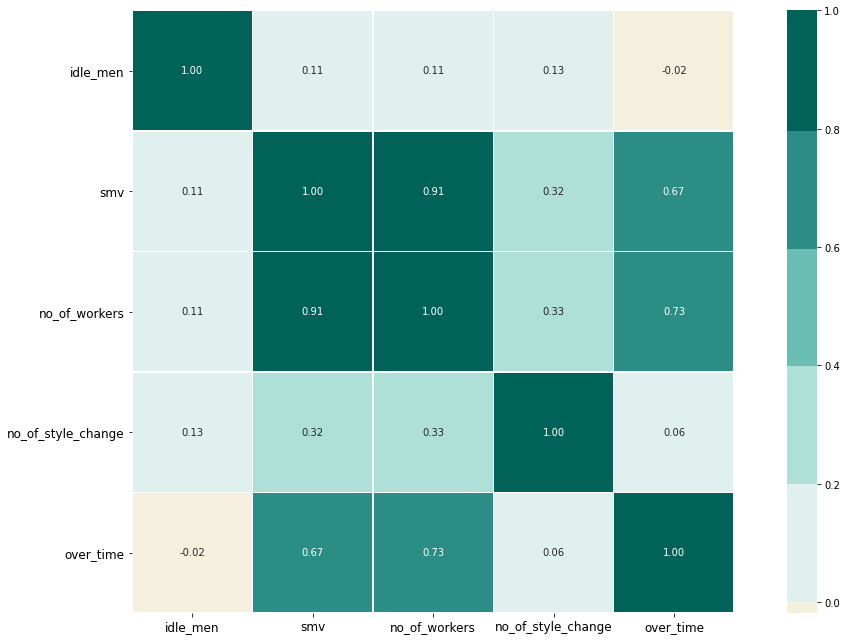

In [ ]:
df2 = df.loc[:,["idle_men", "smv", "no_of_workers", "no_of_style_change","over_time"]]
plt.figure(figsize=(15,9))
palette = sns.color_palette("BrBG", 10)
corr=df2.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt=".2f", cmap=palette, center=0,
            square=True, linewidths=.5)
plt.xticks(size=12)
plt.yticks(size=12)
plt.tight_layout()

In [ ]:
multicollinearity, V=np.linalg.eig(corr)
multicollinearity

array([2.67030414, 1.09875582, 0.84931182, 0.2998322 , 0.08179602])

In [ ]:
model = ols("actual_productivity~targeted_productivity+C(day)+C(quarter)+C(department)+\
             C(team)+idle_men+smv+no_of_workers+no_of_style_change", data=df) # define the model
fit = model.fit() #fit the model defined above
print(fit.summary())
print(fit.pvalues)
print(fit.aic)

                             OLS Regression Results                            
Dep. Variable:     actual_productivity   R-squared:                       0.318
Model:                             OLS   Adj. R-squared:                  0.303
Method:                  Least Squares   F-statistic:                     21.00
Date:                 Fri, 30 Jul 2021   Prob (F-statistic):           2.21e-79
Time:                         14:59:13   Log-Likelihood:                 621.06
No. Observations:                 1197   AIC:                            -1188.
Df Residuals:                     1170   BIC:                            -1051.
Df Model:                           26                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

### Interaction analysis

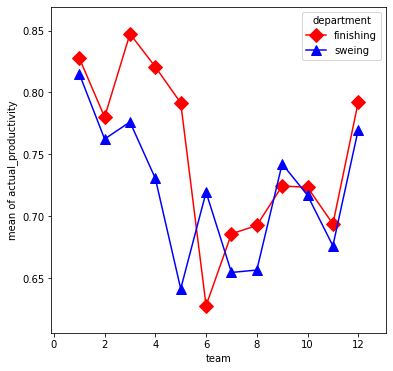

In [ ]:
# Interaction between day and department (no interaction)
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(x=df.day, trace=df.department, response=df.actual_productivity,
                       colors=['red', 'blue'], markers=['D', '^'], ms=10, ax=ax)